### Grading
The final score that you will receive for your programming assignment is generated in relation to the total points set in your programming assignment item—not the total point value in the nbgrader notebook.<br>
When calculating the final score shown to learners, the programming assignment takes the percentage of earned points vs. the total points provided by nbgrader and returns a score matching the equivalent percentage of the point value for the programming assignment. <br>
**DO NOT CHANGE VARIABLE OR METHOD SIGNATURES** The autograder will not work properly if you change the variable or method signatures. 

### Validate Button
Please note that this assignment uses nbgrader to facilitate grading. You will see a **validate button** at the top of your Jupyter notebook. If you hit this button, it will run tests cases for the lab that aren't hidden. It is good to use the validate button before submitting the lab. Do know that the labs in the course contain hidden test cases. The validate button will not let you know whether these test cases pass. After submitting your lab, you can see more information about these hidden test cases in the Grader Output. <br>
***Cells with longer execution times will cause the validate button to time out and freeze. Please know that if you run into Validate time-outs, it will not affect the final submission grading.*** <br>

# Homework 1. Neural Networks
This assignment has mixed types of theoretical and code implementation questions on multilayer perceptron and neural network training.

In [1]:
import math
import pickle
import gzip
import numpy as np
import pandas
import matplotlib.pylab as plt
%matplotlib inline

[Peer Review] Problem 1 - Single-Layer and Multilayer Perceptron Learning
---

**Part A** : Answer this question in this week's Peer Review assignment. Consider learning the following concepts with either a single-layer or multilayer perceptron where all hidden and output neurons utilize *indicator* activation functions. For each of the following concepts, state whether the concept can be learned by a single-layer perceptron. Briefly justify your response by providing weights and biases as applicable:

i. $~ \texttt{ NOT } x_1$

ii. $~~x_1 \texttt{ NOR } x_2$

iii. $~~x_1 \texttt{ XNOR } x_2$ (output 1 when $x_1 = x_2$ and 0 otherwise)

### My Work for Part A

i. NOT x1

I believe you can do this with a single-layer perceptron.

- Use w = -1
- Use threshold of 0 for the activation function

If x1 = True (i.e., > 0), then w * x1 would be False (i.e., <= 0)

ii. x1 NOR x2

This indicates

x1		x2		result  
1		1		0  
1		0		0  
0		1		0  
0		0		1  

This should be possible with a single-layer perceptron by using..

- w1 and w2 equal to -1
- threshold for the activation function of -1

This would mean x1*w1 + x2*w2 results in "False" unless the output is 0, which is greater than -1,
which only happens if x1 and x2 are negative

iii. x1 XNOR x2

This indicates "not exclusive or"

x1		x2		result  
1		1		1  
1		0		0  
0		1		0  
0		0		1  

This one is not linearly separable so it cannot be done with a single perceptron.

**Part B** : Determine an architecture and specific values of the weights and biases in a single-layer or multilayer perceptron with *indicator* activation functions that can learn $x_1 \texttt{ XNOR } x_2$. <br>
In this week's Peer Review, describe your architecture and state your weight matrices and bias vectors. 

Then demonstrate that your solution is correct by implementing forward propagation for your network in Python and showing that it correctly produces the correct boolean output values for each of the four possible combinations of $x_1$ and $x_2$. <br>
Answer the questions about this section in this week's Peer Review assignment.

### My Work for Part B
x1	   x2	  result  
0      0      1  
0      1      0  
1      0      0  
1      1      1  

- The first case listed above ($x = [0, 0]$ -> result = 1) can be checked with a NOR gate. Only this input will yield a result of 1.
- The second case resulting in 1 ($x = [1, 1]$) can be checked using and AND gate. Again, this input is the only one that will yield a result of one.
- Then, if either of these results is true the output should be true, which can be done with an OR gate

For the NOR gate in the first layer
* w = [-1, -1]
* b = +1

For the AND gate in the first layer
* w = [1, 1]
* b = -1

For the OR gate in the second layer
* w = [1, 1]
* b = 0

In [2]:
# implement forward propagation for network
# show that it correctly produces the correct boolean output values 
# for each of the four possible combinations of x1 and x2 
# your code here

def indicator_activation(inpt):
    return (inpt > 0)

def gate(in1, in2, thr):
    return (in1 + in2 + thr)

def XNOR(x1, x2):
    
    # AND
    res1 = gate(1*x1, 1*x2, -1)   # w = [1, 1]
                                  # threshold of 1 --> "-1"
    # NOR
    res2 = gate(-1*x1, -1*x2, +1)   # w = [-1, -1]
                                    # threshold of -1 --> "+1"
        # e.g. -0 + -0 + 1 > 0
        #      -1 + -0 + 1 = 0
    
    h1 = indicator_activation(res1)
    h2 = indicator_activation(res2)
    
    
    # OR
    # w = [1, 1]
    # threshold of 0
    return gate(1*h1, 1*h2, 0)

    
options = [(0, 0),  # expect 1
           (0, 1),  # expect 0
           (1, 0),  # expect 0
           (1, 1)   # expect 1
          ]

for option in options:
    print(option, "-->", XNOR(option[0], option[1]))

(0, 0) --> 1
(0, 1) --> 0
(1, 0) --> 0
(1, 1) --> 1


[15 points, Peer Review] Problem 2 - Back propagation
---

In this problem you'll gain some intuition about why training deep neural networks can be very time consuming.  Consider training the chain-like neural network seen below: 

![chain-like nn](figs/chain_net.png)

Note that this network has three weights $W^1, W^2, W^3$ and three biases $b^1, b^2,$ and $b^3$ (for this problem you can think of each parameter as a single value or as a $1 \times 1$ matrix). Suppose that each hidden and output neuron is equipped with a sigmoid activation function and the loss function is given by 

$$
\ell(y, a^4) = \frac{1}{2}(y - a^4)^2  
$$

where $a^4$ is the value of the activation at the output neuron and $y \in \{0,1\}$ is the true label associated with the training example. 

**Part A**: Suppose each of the weights is initialized to $W^k = 1.0$ and each bias is initialized to $b^k = -0.5$.  Use forward propagation to find the activities and activations associated with each hidden and output neuron for the training example $(x, y) = (0.5,0)$. Show your work. Answer the Peer Review question about this section.

In [3]:
def sigmoid(x):
    return (1.0 /(1 + np.exp(-x)))

w = 1.0
b = -0.5

x = 0.5

z1 = w*x + b
h1 = sigmoid(z1) # h1 = 0.5
print(f"Hidden Layer 1: z1 = {z1} and h1 = {h1}")

z2 = w*h1 + b
h2 = sigmoid(z2) # h2 = 0.5
print(f"Hidden Layer 2: z2 = {z2} and h2 = {h2}")

z3 = w*h2 + b
a = sigmoid(z3)  # a = 0.5
print(f"Output Layer: z3 = {z3} and a = {a}")

Hidden Layer 1: z1 = 0.0 and h1 = 0.5
Hidden Layer 2: z2 = 0.0 and h2 = 0.5
Output Layer: z3 = 0.0 and a = 0.5


For above, please note that...
* __h1, h2, and a__ are the __"activations"__ associated with the hidden and output neurons
* __x, z1, z2, and z3__ are the __"activities"__ associated with the hidden layers and the output 

In [4]:
# LOSS - not requested yet, but wanted to do it

def square_loss(a, y):
    return (0.5 * (y - a)**2)

print(square_loss(0.5, 0))

0.125


**Part B**: Use Back-Propagation to compute the weight and bias derivatives $\partial \ell / \partial W^k$ and $\partial \ell / \partial b^k$ for $k=1, 2, 3$.  Show all work. Answer the Peer Review question about this section. 

### My answer starts here

$h_{1}$ is the output of hidden layer 1  
$h_{2}$ is the output of hidden layer 2

$\partial\ell / \partial\ell = 1$
___
$\partial\ell / \partial\sigma(z_{3}) = a - y = 0.5 - 0 = 0.5$
___
$\partial\ell / \partial z_{3} = \partial \ell / \partial\sigma(z_{3}) * \partial\sigma(z_{3}) / \partial z_{3} = (0.5) * \sigma * (1 - \sigma) = 0.5 * 0.5 * 0.5 = 0.125 $
___

$z_{3} = w_{3}*h_{2} + b_{3}$

Partial Derivatives of $z_{3}$ with respect to $w_{3}$ and $b_{3}$  
$\partial z_{3} / \partial w_{3} = h_{2}$  
$\partial z_{3} / \partial b_{3} = 1$

__Derivatives of loss w.r.t. $W^{3}$ and $b^{3}$__  
$\partial \ell / \partial W^{3} = \partial\ell / \partial z_{3} * \partial z_{3} / \partial W^{3} = 0.125 * h_{2} = 0.0625 $  
$\partial \ell / \partial b^{3} = \partial\ell / \partial z_{3} * \partial z_{3} / \partial b^{3} = 0.125 * 1 = 0.125 $
___
$ h_{2} = \sigma (z_{2}) $

$ \partial \ell / \partial h_{2} = \partial\ell / \partial z_{3} * \partial z_{3} / \partial h^{2} = 0.125 * W^{3} = 0.125 $

$ \partial\ell / \partial z_{2} = \partial \ell / \partial h_{2} * \partial h_{2} / \partial z_{2} = (0.125) * h_{2} * (1 - h_{2}) = (0.125) * (0.5) * (0.5) = 0.03125 $
___
$z_{2} = w_{2}*h_{1} + b_{2}$

Partial Derivatives of $z_{2}$ with respect to $w_{2}$ and $b_{2}$  
$\partial z_{2} / \partial w_{2} = h_{1}$  
$\partial z_{2} / \partial b_{2} = 1$

__Derivatives of loss w.r.t. $W^{2}$ and $b^{2}$__  
$\partial \ell / \partial W^{2} = \partial\ell / \partial z_{2} * \partial z_{2} / \partial W^{2} = 0.03125 * h_{1} = 0.015625 $  
$\partial \ell / \partial b^{2} = \partial\ell / \partial z_{2} * \partial z_{2} / \partial b^{2} = 0.03125 * 1 =  0.03125$
___
$ h_{1} = \sigma (z_{1}) $

$ \partial \ell / \partial h_{1} = \partial\ell / \partial z_{2} * \partial z_{2} / \partial h_{1} = 0.03125 * W^{2} = 0.03125 $

$ \partial\ell / \partial z_{1} = \partial \ell / \partial h_{1} * \partial h_{1} / \partial z_{1} = (0.03125) * h_{1} * (1 - h_{1}) = (0.03125) * (0.5) * (0.5) = 0.0078125$
___

$z_{1} = w_{1}*x + b_{1}$

Partial Derivatives of $z_{1}$ with respect to $w_{1}$ and $b_{1}$  
$\partial z_{1} / \partial w_{1} = x$  
$\partial z_{1} / \partial b_{1} = 1$

__Derivatives of loss w.r.t. $W^{1}$ and $b^{1}$__  
$\partial \ell / \partial W^{1} = \partial\ell / \partial z_{1} * \partial z_{1} / \partial W^{1} =  0.0078125 * x =  0.00390625 $  
$\partial \ell / \partial b^{1} = \partial\ell / \partial z_{1} * \partial z_{1} / \partial b^{1} =  0.0078125 * 1 =  0.0078125 $

**PART C** Implement following activation functions:
* Relu
* Sigmoid
* softmax

In [5]:
import math
import numpy as np

def relu(x):
    # your code here
    return max(0, x)

def sigmoid(x):
    # your code here
    return (1.0 /(1 + np.exp(-x)))
    

def soft_max(x):
    # your code here
    e = np.exp(x)
    return (e / np.sum(e))

In [6]:
# tests relu, sigmoid, and softmax functions 

**PART D** Implement the following Loss functions:
* mean squared error
* mean absolute error
* hinge

In [7]:
import numpy as np

def mean_squared_error(yhat,y):
    # your code here
    return np.square(np.subtract(y,yhat)).mean()
    
    
def mean_absolute_error(yhat,y):
    # your code here
    return np.absolute(np.subtract(y,yhat)).mean()

def hinge(yhat,y):
    # your code here
    loss = 1 - np.multiply(y,yhat)
    l = [loss[i] if loss[i] > 0 else 0 for i in range(len(loss))]
    return np.mean(l)

In [8]:
# My testing
# y = np.array([-1, 1, -1, 1, -1])
# yhat = np.array([-1, -1, -1, 1, 1])

# print(mean_squared_error(yhat, y))
# print(mean_squared_error(y, y))

# print(mean_absolute_error(yhat, y))
# print(mean_absolute_error(y, y))

# print(hinge(yhat, y))
# print(hinge(y, y))

In [9]:
# tests mean_squared_error, mean_absolute_error, and hinge

[Peer Review] Problem 3 - Build a feed-forward neural network
---

In this problem you'll implement a general feed-forward neural network class that utilizes sigmoid activation functions. Your tasks will be to implement forward propagation, prediction, back propagation, and a general train routine to learn the weights in your network via stochastic gradient descent.

The skeleton for the network class is below. Befor filling out the codes below, read the PART X instruction. The place you will complete the code is indicated as "TODO" in the code. Pleaes do not modify other parts of the code.

In [25]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter, ListedColormap
%matplotlib inline

class Network:
    def __init__(self, sizes):
        """
        Initialize the neural network 
        
        :param sizes: a list of the number of neurons in each layer 
        """
        # save the number of layers in the network 
        self.L = len(sizes) 
        
        # store the list of layer sizes 
        self.sizes = sizes  
        
        # initialize the bias vectors for each hidden and output layer 
        self.b = [np.random.randn(n, 1) for n in self.sizes[1:]]
        
        # initialize the matrices of weights for each hidden and output layer 
        self.W = [np.random.randn(n, m) for (m, n) in zip(self.sizes[:-1], self.sizes[1:])]
        
        # initialize the derivatives of biases for backprop 
        self.db = [np.zeros((n, 1)) for n in self.sizes[1:]]
        
        # initialize the derivatives of weights for backprop 
        self.dW = [np.zeros((n, m)) for (m,n) in zip(self.sizes[:-1], self.sizes[1:])]
        
        # initialize the activities on each hidden and output layer 
        self.z = [np.zeros((n, 1)) for n in self.sizes]
        
        # initialize the activations on each hidden and output layer 
        self.a = [np.zeros((n, 1)) for n in self.sizes]
        
        # initialize the deltas on each hidden and output layer 
        self.delta = [np.zeros((n, 1)) for n in self.sizes]
        
        # deltas --> THE GRADIENT OF THE LOSS FUNCTIONS WITH RESPECT TO THE ACTIVITIES (z1, z2, etc.)
        # The deltas are basically dL/dz ... we skip the process of separately calculating the dL/da (the derivative with
        #  respect to the outputs of each layer
        
        # b dimensions -> list with NumPy arrays -> [(3 x 1) (2 x 1)]
        # W dimensions -> list with NumPy arrays -> [(3 x 2) (2 x 3)]
        
        # NOTE: zip() produces (m, n) iterable which is ([2,3], [3,2])
        
        # z dimensions -> list of NumPy arrays -> [(2, 1) (3, 1) (2, 1)]
        # a dimensions -> list of NumPy arrays -> [(2, 1) (3, 1) (2, 1)]
        
        # delta dimensions -> list of NumPy arrays -> [(2, 1) (3, 1) (2, 1)]
        
    def g(self, z):
        """
        sigmoid activation function 
        
        :param z: vector of activities to apply activation to 
        """
        return 1.0 / (1.0 + np.exp(-z))
    
    def g_prime(self, z):
        """
        derivative of sigmoid activation function 
        
        :param z: vector of activities to apply derivative of activation to 
        """
        return self.g(z) * (1.0 - self.g(z))
    
    def grad_loss(self, a, y):
        """
        evaluate gradient of cost function for squared-loss C(a,y) = (a-y)^2/2 
        
        :param a: activations on output layer 
        :param y: vector-encoded label 
        """
        return (a - y)
    
    def forward_prop(self, x): # PART A
        """
        take an feature vector and propagate through network 
        
        :param x: input feature vector 
        """
        if len(x.shape) == 1:
            x = x.reshape(-1, 1)
        # TODO: step 1. Initialize activation on initial layer to x 
        # your code here
        self.a[0] = x
        # self.z[0] =  *should just remain 0*
        
        ## TODO: step 2-4. Loop over layers and compute activities and activations 
        # your code here
        for l in range(1,self.L):  # self.L = 3  --> range(1,3) --> [1, 2]
            self.z[l] = np.matmul(self.W[l-1], self.a[l-1]) + self.b[l-1]
            self.a[l] = self.g(self.z[l])
        
        # return a  --- SEEMS LIKE A DON'T NEED TO RETURN BASED ON THE TEST CALLS OF THIS FUNCTION
            
        # b dimensions -> list with NumPy arrays -> [(3 x 1) (2 x 1)]
        # W dimensions -> list with NumPy arrays -> [(3 x 2) (2 x 3)]
        
        # NOTE: zip() produces (m, n) iterable which is ([2,3], [3,2])
        
        # z dimensions -> list of NumPy arrays -> [(2, 1) (3, 1) (2, 1)]
        # a dimensions -> list of NumPy arrays -> [(2, 1) (3, 1) (2, 1)]
        
    def back_prop(self, x, y):
        """
        Back propagation to get derivatives of C wrt weights and biases for given training example
        
        :param x: training features  
        :param y: vector-encoded label 
        """
        
        if len(y.shape) == 1:
            y = y.reshape(-1, 1)
        
        # TODO: step 1. forward prop training example to fill in activities and activations 
        # your code here
        self.forward_prop(x)
        
        # TODO: step 2. compute deltas on output layer (Hint: python index numbering starts from 0 ends at N-1)
        # your code here
        self.delta[self.L-1] = np.multiply(self.grad_loss(self.a[self.L-1],y),self.g_prime(self.z[self.L-1]))
        
        # TODO: step 3-6. loop backward through layers, backprop deltas, compute dWs and dbs
        # your code here
        for l in range(self.L-2,-1,-1):  # L = 3 --> L - 1 = 2 --> and we need to go over the range [L-1,..,1]
            self.dW[l] = np.matmul(self.delta[l+1], self.a[l].T)
            self.db[l] = self.delta[l+1]
            self.delta[l] = np.multiply( np.matmul(self.W[l].T, self.delta[l+1]), self.g_prime(self.z[l]))
        
        # delta dimensions -> list of NumPy arrays -> [(2, 1) (3, 1) (2, 1)]
        
            
    def train(self, X_train, y_train, X_valid=None, y_valid=None,
              eta=0.25, num_epochs=10, isPrint=True, isVis=False):
        """
        Train the network with SGD 
        
        :param X_train: matrix of training features 
        :param y_train: matrix of vector-encoded labels 
        """
        
        # initialize shuffled indices 
        shuffled_inds = list(range(X_train.shape[0]))
        
        # loop over training epochs (step 1.)
        for ep in range(num_epochs):
            
            # shuffle indices 
            np.random.shuffle(shuffled_inds)
            
            # loop over training examples (step 2.) 
            for ind in shuffled_inds: 
                
                # TODO: step 3. back prop to get derivatives 
                # your code here
                self.back_prop(X_train[ind, :], y_train[ind, :])  # CALLS FORWARD PROPAGATION!
                
                # TODO: step 4. update weights and biases 
                # your code here
                for ll in range(self.L-1):
                    self.W[ll] = self.W[ll] - np.multiply(eta, self.dW[ll])
                    self.b[ll] = self.b[ll] - np.multiply(eta, self.db[ll])            
                
                # Multiply dW by eta ("learning rate") then add to current W values
                # Multiply db by eta ("learning rate") then add to current b values
                
                
            # print mean loss every 10 epochs if requested 
            if isPrint and (ep % 10) == 0:
                print("epoch {:3d}/{:3d}: ".format(ep, num_epochs), end="")
                print("  train loss: {:8.3f}".format(self.compute_loss(X_train, y_train)), end="")
                if X_valid is not None:
                    print("  validation loss: {:8.3f}".format(self.compute_loss(X_valid, y_valid)))
                else:
                    print("")
                    
            if isVis and (ep % 20) == 0:
                self.pretty_pictures(X_train, y_train, decision_boundary=True, epoch=ep)

                    
    def compute_loss(self, X, y):
        """
        compute average loss for given data set 
        
        :param X: matrix of features 
        :param y: matrix of vector-encoded labels 
        """
        loss = 0
        if len(X.shape) == 1:
            X = X[np.newaxis, :]
        if len(y.shape) == 1:
            y = y[np.newaxis, :]
        for x, t in zip(X, y):
            #print(f"*** New Iteration ****")
            #print(f"{x}\n\n{t}")
            #print(self.a[-1])
            self.forward_prop(x)
            if len(t.shape) == 1:
                t = t.reshape(-1, 1)
            loss += 0.5 * np.sum((self.a[-1] - t) ** 2)
        return loss / X.shape[0]
    
    
    def gradient_check(self, x, y, h=1e-5):
        """
        check whether the gradient is correct for X, y
        
        Assuming that back_prop has finished.
        """
        for ll in range(self.L - 1):
            oldW = self.W[ll].copy()
            oldb = self.b[ll].copy()
            for i in range(self.W[ll].shape[0]):
                for j in range(self.W[ll].shape[1]):
                    self.W[ll][i, j] = oldW[i, j] + h
                    lxph = self.compute_loss(x, y)
                    self.W[ll][i, j] = oldW[i, j] - h
                    lxmh = self.compute_loss(x, y)
                    grad = (lxph - lxmh) / (2 * h)
                    assert abs(self.dW[ll][i, j] - grad) < 1e-5
                    self.W[ll][i, j] = oldW[i, j]
            for i in range(self.b[ll].shape[0]):
                j = 0
                self.b[ll][i, j] = oldb[i, j] + h
                lxph = self.compute_loss(x, y)
                self.b[ll][i, j] = oldb[i, j] - h
                lxmh = self.compute_loss(x, y)
                grad = (lxph - lxmh) / (2 * h)
                assert abs(self.db[ll][i, j] - grad) < 1e-5
                self.b[ll][i, j] = oldb[i, j]
        
        
            
    def pretty_pictures(self, X, y, decision_boundary=False, epoch=None):
        """
        Function to plot data and neural net decision boundary
        
        :param X: matrix of features 
        :param y: matrix of vector-encoded labels 
        :param decision_boundary: whether or not to plot decision 
        :param epoch: epoch number for printing 
        """
        
        mycolors = {"blue": "steelblue", "red": "#a76c6e"}
        colorlist = [c for (n,c) in mycolors.items()]
        colors = [colorlist[np.argmax(yk)] for yk in y]

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
        
        if decision_boundary:
            xx, yy = np.meshgrid(np.linspace(-1.25,1.25,300), np.linspace(-1.25,1.25,300))
            grid = np.column_stack((xx.ravel(), yy.ravel()))
            grid_pred = np.zeros_like(grid[:,0])
            for ii in range(len(grid_pred)):
                self.forward_prop(grid[ii,:])
                grid_pred[ii] = np.argmax(self.a[-1])
            grid_pred = grid_pred.reshape(xx.shape)
            cmap = ListedColormap([
                colorConverter.to_rgba('steelblue', alpha=0.30),
                colorConverter.to_rgba('#a76c63', alpha=0.30)])
            plt.contourf(xx, yy, grid_pred, cmap=cmap)
            if epoch is not None: plt.text(-1.23,1.15, "epoch = {:d}".format(epoch), fontsize=16)

        plt.scatter(X[:,0], X[:,1], color=colors, s=100, alpha=0.9)
        plt.axis('off')
        
def generate_data(N, config="checkerboard"):
    X = np.zeros((N,2))
    y = np.zeros((N,2)).astype(int)
    
    if config=="checkerboard":
        nps, sqlen = N//9, 2/3
        ctr = 0
        for ii in range(3):
            for jj in range(3):
                X[ctr * nps : (ctr + 1) * nps, :] = np.column_stack(
                    (np.random.uniform(ii * sqlen +.05-1, (ii+1) * sqlen - .05 -1, size=nps),
                     np.random.uniform(jj * sqlen +.05-1, (jj+1) * sqlen - .05 -1, size=nps))) 
                y[ctr*nps:(ctr+1)*nps,(3*ii+jj)%2] = 1 
                ctr += 1
                
    if config=="blobs":            
        X, yflat = datasets.make_blobs(n_samples=N, centers=[[-.5,.5],[.5,-.5]],
                                       cluster_std=[.20,.20],n_features=2)
        for kk, yk in enumerate(yflat):
            y[kk,:] = np.array([1,0]) if yk else np.array([0,1])
            
    
    if config=="circles":
        kk=0
        while kk < N / 2:
            sample = 2 * np.random.rand(2) - 1 
            if np.linalg.norm(sample) <= .45:
                X[kk,:] = sample 
                y[kk,:] = np.array([1,0])
                kk += 1 
        while kk < N:
            sample = 2 * np.random.rand(2) - 1
            dist = np.linalg.norm(sample)
            if dist < 0.9 and dist > 0.55:
                X[kk,:] = sample 
                y[kk,:] = np.array([0,1])
                kk += 1
                
    if config=="moons":
        X, yflat = datasets.make_moons(n_samples=N, noise=.05)
        X[:,0] = .5 * (X[:,0] - .5)
        X[:,1] = X[:,1] - .25
        for kk, yk in enumerate(yflat):
            y[kk, :] = np.array([1,0]) if yk else np.array([0,1])
            
    return X, y

from IPython.core.display import HTML
HTML("""
<style>
.MathJax nobr>span.math>span{border-left-width:0 !important};
</style>
""")        

We'll be using our network to do binary classification of two-dimensional feature vectors.  Scroll down to the **Helper Functions** and examine the function ``generate_data``. Then mess around with the following cell to look at the various data sets available.  

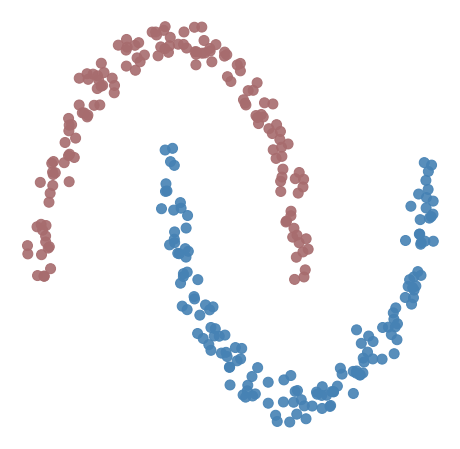

In [11]:
# play with this cell to look at the various data sets available
# your code here

nn = Network([2,3,2])
# X_train, y_train = generate_data(300, "blobs") # <--- linear margin
# X_train, y_train = generate_data(500, "blobs") # <--- linear margin
X_train, y_train = generate_data(300, "moons")  # <-- crescent shaped margin
# X_train, y_train = generate_data(300, "circles")  # <-- circular margin
# X_train, y_train = generate_data(300, "checkerboard")  # <-- tic-tac-toe board boundaries ... need 4 different linear boundaries
nn.pretty_pictures(X_train, y_train, decision_boundary=False)

 Go up to the ``__init__`` function in the ``Network Class``.  How are we initializing a network?  What data structures are we using to store things like weights, biases, deltas, etc? 

### How are we initializing the network?

`Network([2,3,2])`

I believe this means there are three layers to the network. Still need to determine below if...
* First layer of 2 perceptrons is (1) the data inputs OR (2) a linear combination of the inputs?
* What kind of output are we looking for?
    * One value? - linear combination of the perceptrons in the last layer?
    * Two values? - outputs from the last layer?

### What data structures are we using?

Weights --> NumPy array  
Biases --> NumPy array  
Deltas --> NumPy array  

Samples --> NumPy array

*Information about the network is stored in lists*


**PART A.** Implementing Forward Propagation. 

Complete the ``forward_prop`` function to implement forward propagation.  Your function should take in a single training example ``x`` and propagate it forward in the network, setting the activations and activities on the hidden and output layers.  Remember that the pseudocode that we wrote for forward-prop looked as follows: 

1. $\quad$Initialize ${\bf a}^0 = {\bf x}$
2. $\quad$For $\ell = 0, \ldots, L-1$: 
3. $\quad\quad\quad{\bf z}^{\ell+1} = W^\ell {\bf a}^\ell + {\bf b}^\ell$
3. $\quad\quad\quad{\bf a}^{\ell+1} = g({\bf z}^{\ell+1})$

When you think you're done, we can instantiate a ``Network`` with with $2$ neurons in the input layer, $3$ neurons in the sole hidden layer, and $2$ neurons in the output layer, and then forward prop one of the training examples. 

Check that your indexing was correct by making sure that all of the activations are now non-zero (remember, we initialized them to vectors of zeros). 

What other things could we check?<br>
Answer the question about this section in this week's Peer Review assignment. 

### Structure
* ONE HIDDEN LAYER!
* 2 neurons in the output layer...
    * so the output is two values I guess

In [12]:
# test your forward_prop function
nn = Network([2,3,2])
nn.forward_prop(X_train[0])
nn.z

[array([[0.],
        [0.]]),
 array([[-0.55350501],
        [-1.46940911],
        [ 1.00273303]]),
 array([[-1.43956151],
        [-0.67431606]])]

In [13]:
# my test
nn.a

[array([[-0.8037889 ],
        [-0.14136411]]),
 array([[0.3650516 ],
        [0.18703244],
        [0.73159558]]),
 array([[0.19161326],
        [0.33753108]])]

**PART B.** Implementing Back Propagation

OK, now it's time to implement back propagation.  Complete the function ``back_prop`` in the ``Network`` class to use a single training example to compute the derivatives of the loss function with respect to the weights and the biases.  Remember, the pseudocode for back-prop was as follows: 

1. $\quad$Forward propagate the training example ${\bf x}$, ${\bf y}$
2. $\quad$Compute the $\delta^L = \dfrac{\partial \mathscr{L}}{\partial {\bf a}^L} \odot g'({\bf z}^L)$
3. $\quad$For $\ell = L-1, \ldots, 1$: 
4. $\quad\quad\quad \dfrac{\partial \mathscr{L}}{\partial W^\ell} = \delta^{\ell+1} ({\bf a}^\ell)^T$
5. $\quad\quad\quad \dfrac{\partial \mathscr{L}}{\partial {\bf b}^\ell} = \delta^{\ell+1}$
6. $\quad\quad\quad\delta^{\ell} = (W^\ell)^T\delta^{\ell+1} \odot g'({\bf z}^\ell)$

When you think you're done, instantiate a small ``Network`` and call back-prop for a single training example.  

Check that it's likely working by checking that the derivative matrices ``dW`` and ``db`` are nonzero. <br>
Answer the question about this section in this week's Peer Review assignment. 

In [14]:
# test back_prop
nn = Network([2,3,2])
nn.back_prop(X_train[0,:], y_train[0,:])
print(nn.W[0])

[[ 1.11588642  1.14752723]
 [ 0.6267156   1.56506909]
 [-0.58567922 -0.56432795]]


In [15]:
# test gradient_check 
nn.gradient_check(X_train[0, :], y_train[0, :])
print(nn.W[0])

[[ 1.11588642  1.14752723]
 [ 0.6267156   1.56506909]
 [-0.58567922 -0.56432795]]


**Note:** Next week, we will cover stochastic gradient descent. We encourage you to complete the following sections to train your model and get some results if you know how to do so. These sections are ungraded, so don't feel pressure to skip ahead a week in the material. 

**PART C. [Ungraded]** Implementing trainning using stochastic gradient descent 

OK, now let's actually train a neural net!  Complete the missing code in ``train`` to loop over the training data in random order, call back-prop to get the derivatives, and then update the weights and the biases via SGD. SGD uses minibatch to update weights. The training algorithm is following.
1. For epoch = 0,1,...,N:
2.     For (Xbatch, ybatch) in minibatches:
3.         Compute gradients using backpropagation for the minibatch data
4.         Update the weights (W, b) in the all layers (use loop over layer)    

When you think you're done, execute the following code and watch the training loss evolve over the training process.  If you've done everything correctly, it'll hopefully go down! <br><br>
Check out the solution in this week's Peer Review assignment. 

**PART D.[Ungraded]**     
OK! If you think you've worked out the bugs, let's start looking at the results. We'll build a simple neural network, train it on a training set, and watch the decision boundary of our classifier evolve to fit the data. We can do this by running similar code as above, but with the isVis flag set to True. Note that producing the plots takes considerable computational work, so things will go a bit slower now.

Start with the blobs data set, and then move on to more complicated data sets like moons, circles, and finally the checkerboard. Note that for these more complicated geometries, it'll probably be necessary to chain the number of neurons in your hidden layer, or even add more hidden layers! <br>
Check out the solution in this week's Peer Review assignment. 

## MOONS!

epoch   0/101:   train loss:    0.092  validation loss:    0.093
epoch  10/101:   train loss:    0.082  validation loss:    0.085
epoch  20/101:   train loss:    0.089  validation loss:    0.090
epoch  30/101:   train loss:    0.075  validation loss:    0.077
epoch  40/101:   train loss:    0.067  validation loss:    0.069
epoch  50/101:   train loss:    0.034  validation loss:    0.034
epoch  60/101:   train loss:    0.007  validation loss:    0.007
epoch  70/101:   train loss:    0.003  validation loss:    0.003
epoch  80/101:   train loss:    0.002  validation loss:    0.002
epoch  90/101:   train loss:    0.002  validation loss:    0.001
epoch 100/101:   train loss:    0.001  validation loss:    0.001


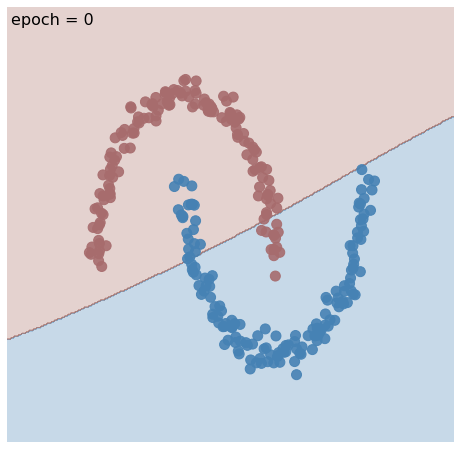

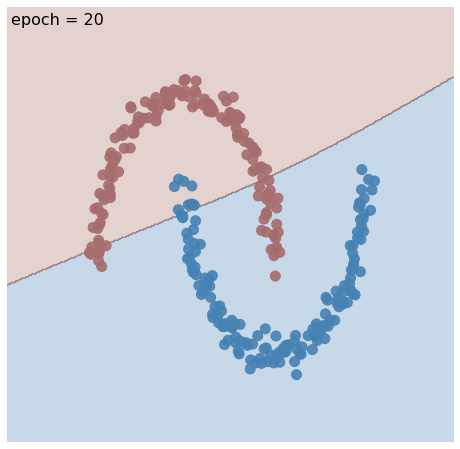

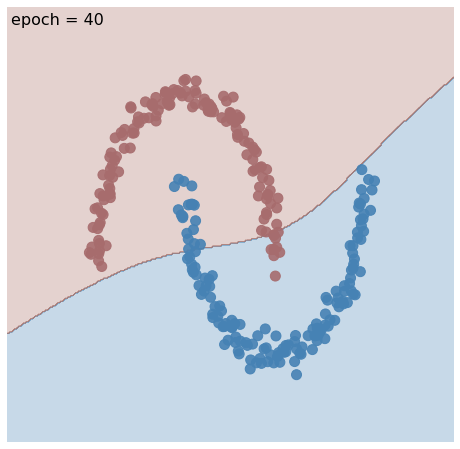

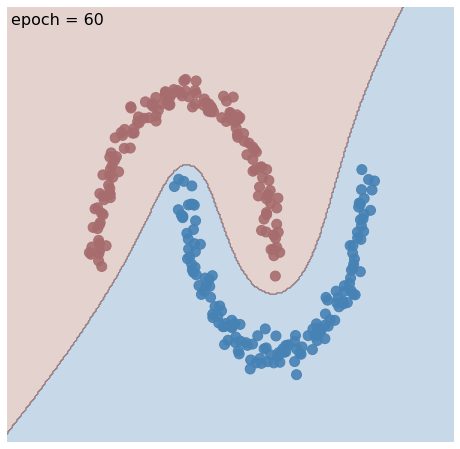

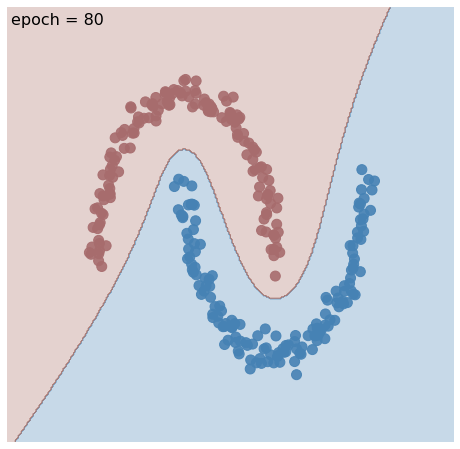

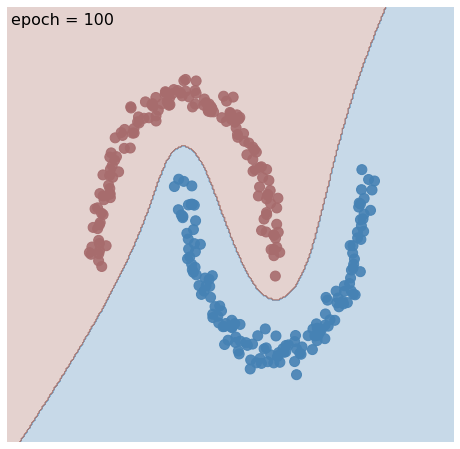

In [18]:
# MOONS
X_train, y_train = generate_data(300, "moons")
X_valid, y_valid = generate_data(300, "moons")

# Build a model and train using the train and validation data. Tweak model and training hyperparameters and display the results.
nn = Network([2, 30, 15, 2])
nn.train(X_train, y_train, X_valid, y_valid, eta=0.25, num_epochs=101, isPrint=True, isVis=True)

## CIRCLES

epoch   0/101:   train loss:    0.279  validation loss:    0.279
epoch  10/101:   train loss:    0.167  validation loss:    0.160
epoch  20/101:   train loss:    0.028  validation loss:    0.030
epoch  30/101:   train loss:    0.012  validation loss:    0.013
epoch  40/101:   train loss:    0.008  validation loss:    0.007
epoch  50/101:   train loss:    0.006  validation loss:    0.006
epoch  60/101:   train loss:    0.004  validation loss:    0.004
epoch  70/101:   train loss:    0.003  validation loss:    0.003
epoch  80/101:   train loss:    0.003  validation loss:    0.002
epoch  90/101:   train loss:    0.002  validation loss:    0.002
epoch 100/101:   train loss:    0.002  validation loss:    0.002


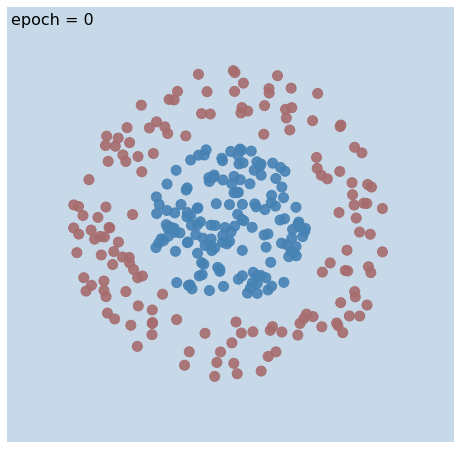

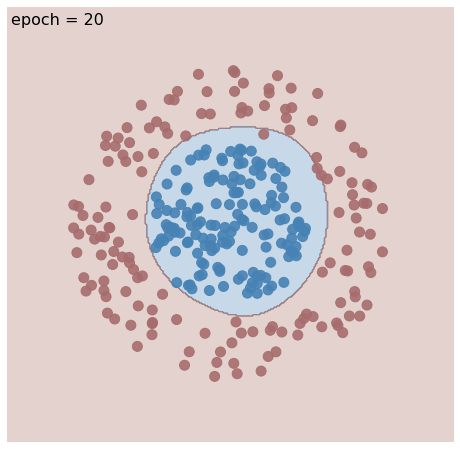

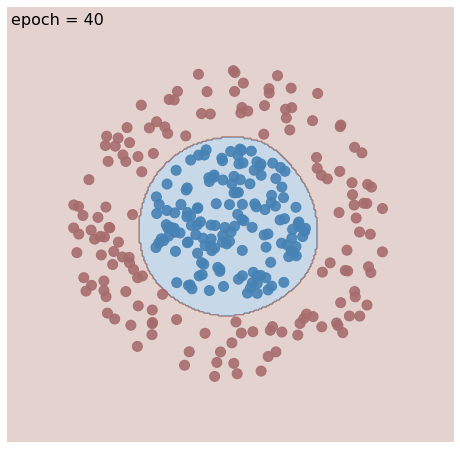

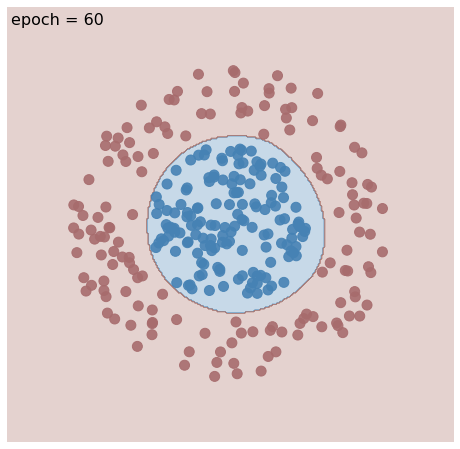

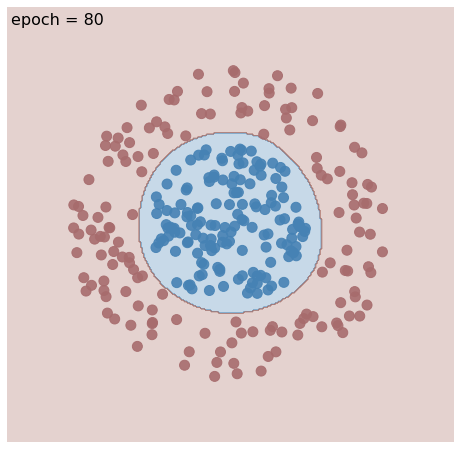

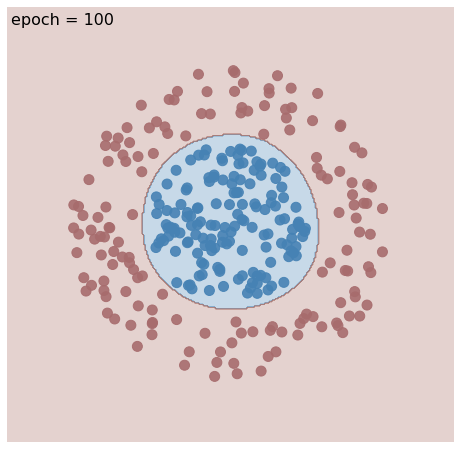

In [20]:
# MOONS
X_train, y_train = generate_data(300, "circles")
X_valid, y_valid = generate_data(300, "circles")

# Build a model and train using the train and validation data. Tweak model and training hyperparameters and display the results.
nn = Network([2, 30, 15, 2])
nn.train(X_train, y_train, X_valid, y_valid, eta=0.25, num_epochs=101, isPrint=True, isVis=True)

## BLOBS 

epoch   0/101:   train loss:    0.294  validation loss:    0.294
epoch  10/101:   train loss:    0.247  validation loss:    0.247
epoch  20/101:   train loss:    0.255  validation loss:    0.255
epoch  30/101:   train loss:    0.245  validation loss:    0.245
epoch  40/101:   train loss:    0.239  validation loss:    0.240
epoch  50/101:   train loss:    0.235  validation loss:    0.243
epoch  60/101:   train loss:    0.195  validation loss:    0.209
epoch  70/101:   train loss:    0.083  validation loss:    0.096
epoch  80/101:   train loss:    0.023  validation loss:    0.037
epoch  90/101:   train loss:    0.017  validation loss:    0.026
epoch 100/101:   train loss:    0.010  validation loss:    0.021


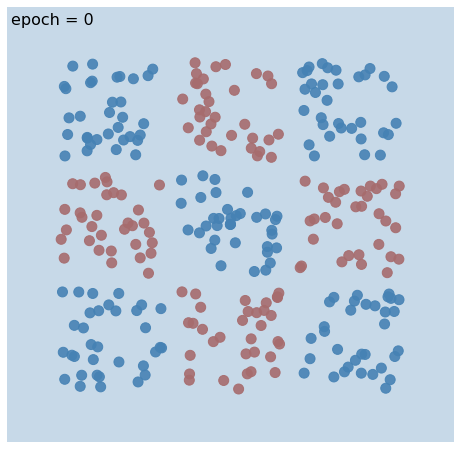

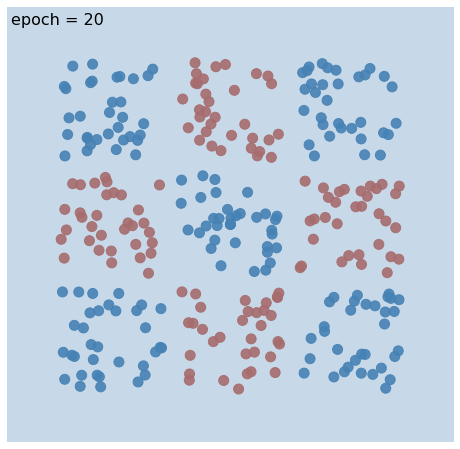

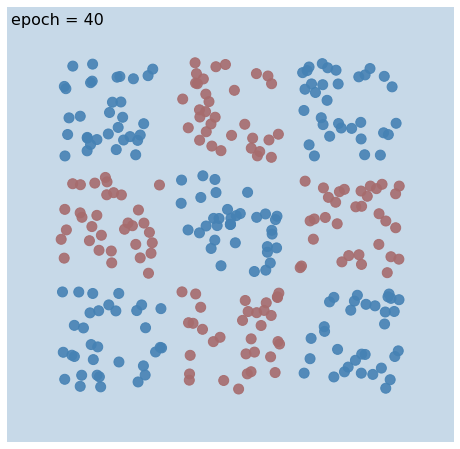

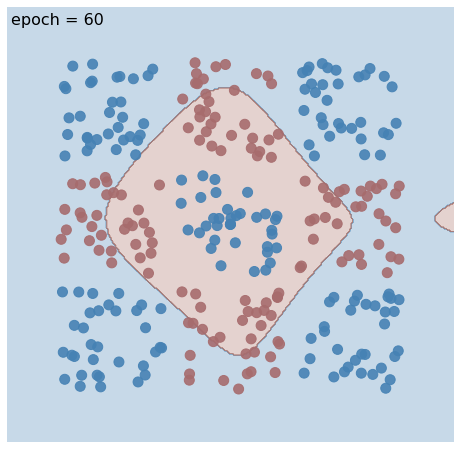

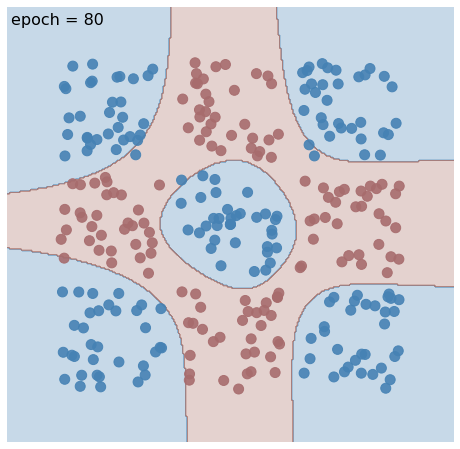

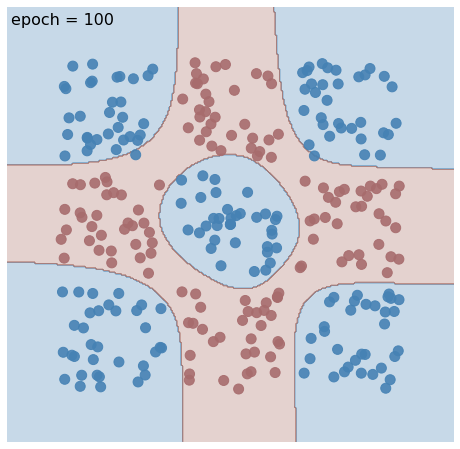

In [22]:
# MOONS
X_train, y_train = generate_data(300, "checkerboard")
X_valid, y_valid = generate_data(300, "checkerboard")

# Build a model and train using the train and validation data. Tweak model and training hyperparameters and display the results.
nn = Network([2, 15, 30, 15, 2])
nn.train(X_train, y_train, X_valid, y_valid, eta=0.25, num_epochs=101, isPrint=True, isVis=True)

In [28]:
## TESTING SOMETHING THAT IS CONFUSING ME
#nn.compute_loss(X_train[0:10,:],y_train[0:10,:])
print(X_train[0:5,:])
print(y_train[0:5,:])

[[-0.52462877 -0.49563912]
 [-0.84920491 -0.38896801]
 [-0.62519792 -0.39714813]
 [-0.83286386 -0.86740106]
 [-0.84114096 -0.93106896]]
[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]
